In [1]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
from collections import Counter, deque
from torch.utils.tensorboard import SummaryWriter
torch.manual_seed(42)

/home/assaf-taubenfeld/Projects/shakespeare/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Length of text: 5436475 characters
Number of unique characters: 84
First 100 characters:
  From fairest creatures we desire increase,
  That thereby beauty's rose might never die,
  But as 


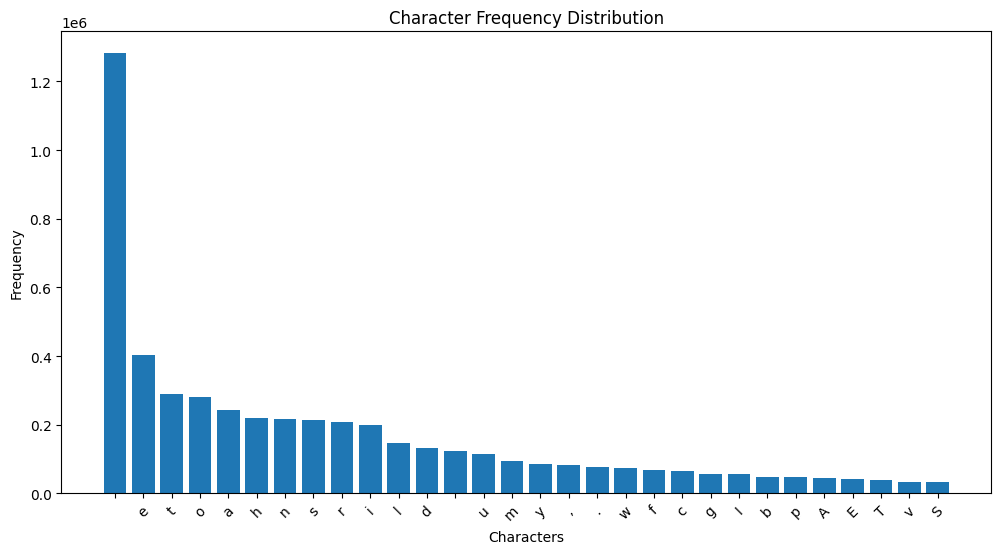

In [2]:
# Loading the shakespeare.txt file
f_name = 'shakespeare.txt'
with open('shakespeare.txt', "r") as f:
    text = f.read()

print(f"Length of text: {len(text)} characters")
print(f"Number of unique characters: {len(set(text))}")
print(f"First 100 characters:\n{text[:100]}")

# plot the distribution of character frequencies
char_counts = Counter(text)
def plot_char_distribution(char_counts):
    """Plot the distribution of character frequencies."""
    chars, counts = zip(*char_counts.most_common(30))  # Get top 30 characters
    plt.figure(figsize=(12, 6))
    plt.bar(chars, counts)
    plt.xlabel('Characters')
    plt.ylabel('Frequency')
    plt.title('Character Frequency Distribution')
    plt.xticks(rotation=45)
    plt.show()
plot_char_distribution(char_counts)

In [ ]:
# x, y = next(iter(train_loader))
# print("Example of a training batch instance:", end='\n\n')
# print(f"Input:'{tokenizer.decode(x[0].tolist())}'") # Decode the first input sequence
# print("=" * 50)
# print(f"Target:'{tokenizer.decode(y[0].tolist())}'") # Decode the first target sequence

In [3]:
from impl.model_config import GPT2Config
from impl.model import GPT2
from impl.tokenizer import CharacterTokenizer
from impl.data_module import ShakespeareDataModule
import config
from config import BLOCK_SIZE, TRAIN_RATIO, BATCH_SIZE, NUM_WORKERS

tokenizer = CharacterTokenizer(text)

data_module = ShakespeareDataModule(text, tokenizer=tokenizer, block_size=BLOCK_SIZE, train_ratio=TRAIN_RATIO)
data_module.setup()

train_loader = data_module.train_dataloader(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_loader = data_module.val_dataloader(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS )

gpt_config = GPT2Config(vocab_size=len(tokenizer))
train_loader = data_module.train_dataloader(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_loader = data_module.val_dataloader(batch_size=BATCH_SIZE, num_workers=NUM_WORKERS )


model = GPT2(gpt_config)
model.to(gpt_config.device)
print(f"device: {gpt_config.device}")
optimizer = torch.optim.AdamW(model.parameters(), lr=gpt_config.lr, weight_decay=0.01)

total_params = 0
for name, param in model.named_parameters():
    total_params += param.numel()
print(f"Total parameters: {total_params:,}")

device: cpu
Total parameters: 221,908


In [4]:
from impl.trainer import Trainer

trainer = Trainer(model=model, optimizer=optimizer, config=gpt_config)

# train the model
results = trainer.train(train_loader=train_loader, val_loader=val_loader)

Starting training...
Training for 10 epochs
Training batches: 305794, Validation batches: 33970
Device: cpu

Epoch 1/10


Training Epoch 1:  98%|█████████▊| 300270/305794 [1:54:41<02:06, 43.64it/s, loss=1.3252, avg_loss=1.2959, lr=3.00e-04]  


KeyboardInterrupt: 

In [ ]:
from impl.generation import pipeline

generator = pipeline(model, tokenizer, k=10)
print(generator('to be or not to be', max_len=1024))